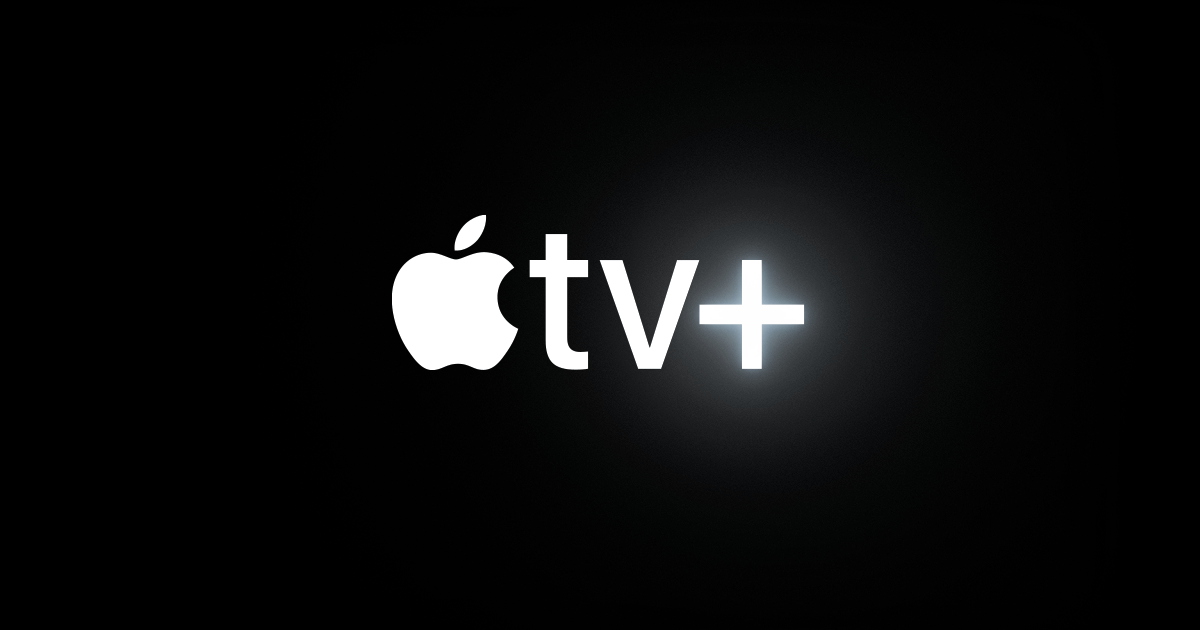

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [2]:
appletv = pd.read_csv('apple_titles.csv')

In [3]:
apple = appletv.copy()

In [4]:
def null_rate_fn(df):
    for i in df.columns:
        null_rate = df[i].isna().sum()/len(df) *100
        if null_rate > 0 :
            print('{} null rate is {}%'.format(i, round(null_rate,2)))

In [5]:
null_rate_fn(apple)

age_certification null rate is 6.47%
seasons null rate is 36.47%
imdb_id null rate is 0.59%
imdb_score null rate is 1.76%
imdb_votes null rate is 2.35%
tmdb_score null rate is 1.76%


In [6]:
if len(apple[(apple['type'] == 'MOVIE') & apple['seasons'].isna()]) == apple['seasons'].isna().sum():
    print('1')
else:
    print('0')

1


In [7]:
apple['seasons'] = apple['seasons'].fillna('0')
apple['age_certification'] = apple['age_certification'].fillna('0')

In [8]:
apple['primary_genre'] = apple['genres'].apply(lambda x: x.strip("[ ").strip("]").split(",")[0])

In [9]:
apple['primary_genre'] = apple['primary_genre'].str.replace("'", "")

In [10]:
apple['production_country'] = apple['production_countries'].apply(lambda x: x.strip("[ ").strip("]").split(",")[0])

In [11]:
apple['production_country'] = apple['production_country'].str.replace("'", "")

In [12]:
apple.production_country.unique()

array(['US', 'IT', 'GB', 'CA', 'CN', 'IL', 'AT', 'FR', 'IE', 'MX', 'AU',
       'IN', 'ES', 'KR', 'TR'], dtype=object)

In [13]:
import pycountry

In [14]:
abbreviated_countries = apple['production_country']

full_countries = []
for abbreviations in abbreviated_countries:
    country_names = []
    for abbreviation in abbreviations.strip("[]'").split(', '):
        try:
            country = pycountry.countries.get(alpha_2=abbreviation.strip())
            if country is not None:
                country_names.append(country.name)
        except KeyError:
            pass
    full_countries.append(country_names)

In [16]:
apple['country_name'] = full_countries

In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [19]:
example = apple.description[0]

In [20]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.5448925, 'roberta_neu': 0.3904495, 'roberta_pos': 0.06465794}


In [21]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [22]:
apple['description'] = apple['description'].astype(str)

In [23]:
res = {}
for i, row in tqdm(apple.iterrows(), total=len(apple)):
    try:
        text = row['description']
        myid = row['id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/170 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(apple, how='left')

In [25]:
showtime = results_df.copy()

In [26]:
# df['column_name'] = df['column_name'].replace("", "No Data")
showtime['production_country'] = showtime['production_country'].replace("","No Data")
showtime['country_name'] = showtime['country_name'].replace("","No Data")

In [28]:
null_rate_fn(apple)

imdb_id null rate is 0.59%
imdb_score null rate is 1.76%
imdb_votes null rate is 2.35%
tmdb_score null rate is 1.76%


# Data Cleaning Done

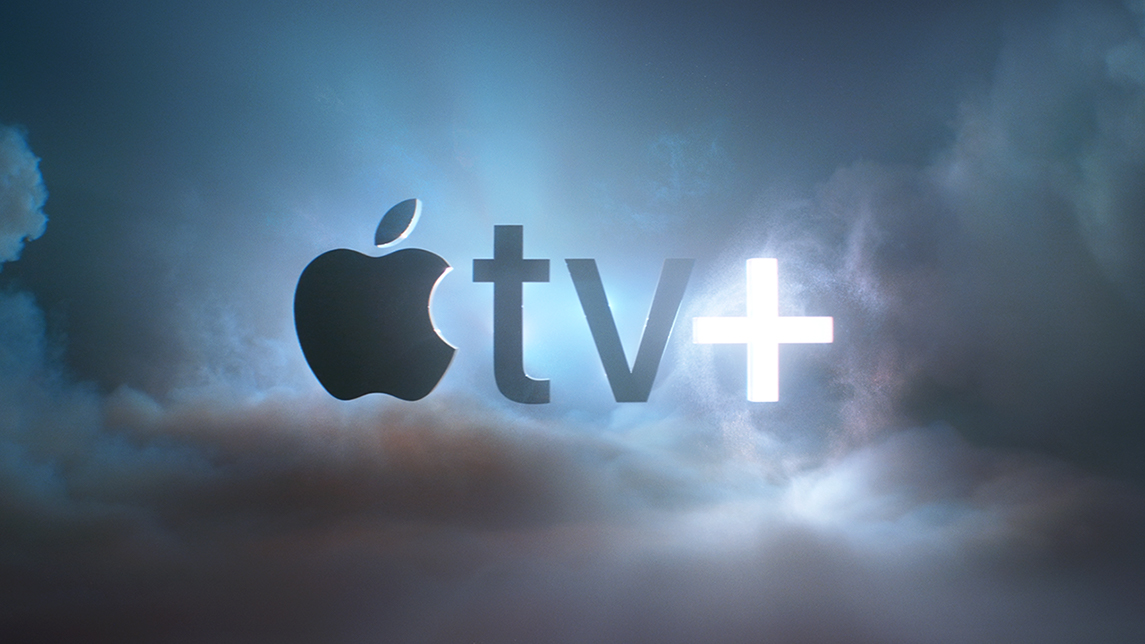

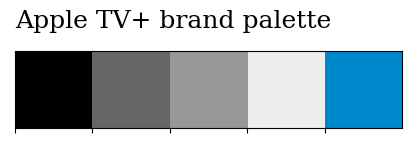

In [30]:
# Palette
sns.palplot(['#000000','#666666', '#979797','#eeeeee','#0088cc'])

plt.title("Apple TV+ brand palette ",loc='left',fontfamily='serif',fontsize=18,y=1.2)
plt.show()

In [33]:
count_data = showtime['type'].value_counts()

# Create a horizontal bar chart
fig = go.Figure(data=go.Bar(
    y=count_data.index,
    x=count_data.values,
    orientation='h',
    marker=dict(color=['#666666','#0088cc'])
))

# Set title and axis labels
fig.update_layout(
    title='Content on Apple TV+ ',
    xaxis_title='Count',
    yaxis_title='Type of Content', title_x = 0.5
)
fig.show()

In [34]:
top_countries = pd.DataFrame(showtime['production_country'].value_counts()[:10])
top_countries = top_countries.reset_index()
top_countries = top_countries[top_countries['index'] != 'No Data']
top_countries

,index,production_country
0,US,125
1,GB,17
2,CA,9
3,IE,3
4,ES,3
5,IL,2
6,FR,2
7,MX,2
8,IT,1
9,CN,1


In [35]:
top_countries = top_countries.rename(columns = {
    'index' : 'production_country',
    'production_country' : 'content_produced'
})
top_countries

,production_country,content_produced
0,US,125
1,GB,17
2,CA,9
3,IE,3
4,ES,3
5,IL,2
6,FR,2
7,MX,2
8,IT,1
9,CN,1


In [121]:
top_countries = top_countries[:5]
fig = px.pie(top_countries, values='content_produced', names='production_country',
             title='Contribution of Content Produced by Top 5 Countries on Apple TV+')

# Change the color palette
fig.update_traces(marker=dict(colors=['#000000','#666666', '#979797','#eeeeee','#0088cc']))

# Set the text position and information to be displayed
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

In [38]:
country_order = showtime['production_country'].value_counts()[:11].index
data = showtime[['type', 'production_country']].groupby('production_country')['type'].value_counts().unstack().loc[country_order]
data['sum'] = data.sum(axis=1)
data_ratio = (data.T / data['sum']).T[['MOVIE', 'SHOW']].sort_values(by='MOVIE',ascending=False)[::-1]
data_ratio = data_ratio.reset_index()

In [39]:
data_ratio = data_ratio[data_ratio['index'] != 'No Data']

In [40]:
data_ratio.rename(columns = {'index':'country_code'}, inplace = True)
data_ratio['MOVIE'] = round(data_ratio['MOVIE'], 2)
# data_ratio['MOVIE'] = (data_ratio['MOVIE'] * 100).astype(str) + '%'

In [41]:
data_ratio['SHOW'] = round(data_ratio['SHOW'],2)
data_ratio

type,country_code,MOVIE,SHOW
0,MX,NaN,1.00
1,IL,NaN,1.00
2,IE,NaN,1.00
3,CA,0.33,0.67
4,GB,0.35,0.65
5,US,0.36,0.64
6,FR,0.50,0.50
7,ES,0.67,0.33
8,AT,1.00,NaN
9,CN,1.00,NaN


In [122]:
fig = go.Figure()
# ['#221f1f', '#b20710', '#e50914','#f5f5f1','#ffffff']
# Add horizontal bar traces for MOVIE and SHOW
fig.add_trace(go.Bar(
    y=data_ratio.country_code,
    x=data_ratio['MOVIE'],
    name='MOVIE',
    orientation='h',
    marker=dict(color='#000000'),
    text=(data_ratio['MOVIE'] * 100).astype(str) + '%',  # Add text as percentages
    textposition='inside',  # Set text position inside the bars
    textfont=dict(color='white')  # Set text color
))

fig.add_trace(go.Bar(
    y=data_ratio.country_code,
    x=data_ratio['SHOW'],
    name='SHOW',
    orientation='h',
    marker=dict(color='#0088cc'),
    text=(data_ratio['SHOW'] * 100).astype(str) + '%',  # Add text as percentages
    textposition='inside',  # Set text position inside the bars
    textfont=dict(color='white')  # Set text color
))

# Set the layout
fig.update_layout(
    title='Content Distribution of Apple TV+ by Country',
    barmode='stack',
    yaxis_title='Top 10 Countries',
    xaxis=dict(showticklabels=False), title_x = 0.5 # Hide the x-axis tick labels
)

fig.show()

In [43]:
genre_distribution = pd.DataFrame(showtime.groupby('primary_genre')['type'].value_counts())
genre_distribution = genre_distribution.unstack().reset_index().fillna(0).drop(0)
genre_distribution['SUM'] = genre_distribution.sum(axis = 1)

/var/folders/kd/vczjh0f55158sc6lflbyfd4w0000gn/T/ipykernel_66266/3203419532.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [44]:
genre_distribution.columns = ['primary_genre', 'MOVIE', 'SHOW', 'total']

In [45]:
genre_distribution = genre_distribution.sort_values('total', ascending = False)

In [123]:
fig1 = go.Figure()
fig1.add_trace(go.Bar(
    x=genre_distribution['primary_genre'],
    y=genre_distribution['MOVIE'],
    name='MOVIE',
    marker=dict(color='#000000'),
))

fig1.add_trace(go.Bar(
    x=genre_distribution['primary_genre'],
    y=genre_distribution['SHOW'],
    name='SHOW',
    marker=dict(color='#0088cc'),
))

fig1.update_layout(
    title='Content Distribution by Genre on Apple TV+',
    xaxis_title='Genre',
    yaxis_title='Content on Apple TV+',
    barmode='stack'
)
fig1.show()

In [48]:
rating_distribution = pd.DataFrame(showtime.groupby('age_certification')['type'].value_counts())
# rating_distribution = genre_distribution.unstack().reset_index().fillna(0).drop(0)
rating_distribution = rating_distribution.unstack().reset_index().fillna(0)
rating_distribution['SUM'] = rating_distribution.sum(axis = 1)
rating_distribution.columns = ['age_certification','MOVIE','SHOW','Total']

/var/folders/kd/vczjh0f55158sc6lflbyfd4w0000gn/T/ipykernel_66266/2154306660.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [49]:
rating_distribution = rating_distribution.sort_values('Total', ascending = False)

In [50]:
rating_distribution = rating_distribution[rating_distribution['age_certification']!='0']

In [124]:
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=rating_distribution['age_certification'],
    y=rating_distribution['MOVIE'],
    name='MOVIE',
    marker=dict(color='#000000'),

))

fig2.add_trace(go.Bar(
    x=rating_distribution['age_certification'],
    y=rating_distribution['SHOW'],
    name='SHOW',
    marker=dict(color='#0088cc'),

))

fig2.update_layout(
    title='Content Distribution by Age Rating Certification on Apple TV+',
    xaxis_title='Genre',
    yaxis_title='Content on Apple TV+',
    barmode='stack', legend_title = 'Type of Content', title_x = 0.5
)

fig2.show()

In [52]:
history = pd.DataFrame(showtime.groupby('release_year')['type'].value_counts())
history = history.unstack().reset_index().fillna(0)
# history['total'] = history.sum(axis = 1)
history.columns = ['release_year','MOVIE','SHOW']
history = history[(history['release_year'] >= 2000) & (history['release_year'] <= 2021)]

In [54]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=history['release_year'],
    y=history['MOVIE'],
    mode='lines',
    name='MOVIE',
    fill='tozeroy',
    line=dict(color='#000000')
))

fig3.add_trace(go.Scatter(
    x=history['release_year'],
    y=history['SHOW'],
    mode='lines',
    name='SHOW',
    fill='tozeroy',
    line=dict(color='#0088cc')
))

# Set the layout
fig3.update_layout(
    title='Content Trend  on Apple TV+ over the Years',
    xaxis_title='Release Year',
    yaxis_title='Content on Apple TV+', showlegend = True, title_x =0.5
)
fig3.show()

In [55]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

In [56]:
demographic_data = showtime.copy()

In [57]:
demographic_data['target_ages'] = demographic_data['age_certification'].map(ratings_ages)

In [58]:
demographic_data = demographic_data.dropna()

In [59]:
# demographic_data.groupby('production_country','target_ages')[['production_country','target_ages']].sum()
demographic_data = demographic_data.groupby(['production_country', 'target_ages']).size().reset_index(name='count').sort_values('count', ascending = False)[:20]
demographic_data

,production_country,target_ages,count
24,US,Adults,56
25,US,Kids,33
27,US,Teens,14
26,US,Older Kids,10
3,CA,Kids,6
10,GB,Adults,6
13,GB,Teens,4
12,GB,Older Kids,3
17,IL,Adults,2
4,CA,Teens,2


In [61]:
total_count = demographic_data['count'].sum()
demographic_data['percentage'] = (demographic_data['count'] / total_count) * 100

fig = px.treemap(demographic_data, path=['production_country', 'target_ages'], values='percentage',
                 color='target_ages', color_discrete_sequence=['#000000','#666666', '#979797','#eeeeee','#0088cc'])

fig.update_layout(title= "Apple TV+'s Country-Level Target Audience",
                  margin=dict(l=20, r=20, t=40, b=20), title_x = 0.5)  # Adjust the margins as needed

fig.show()

In [62]:
demo_genre = showtime.groupby(['production_country', 'primary_genre']).size().reset_index(name='count').sort_values('count', ascending = False)[:20]

In [63]:
demo_genre = demo_genre[demo_genre['production_country']!='No Data']

In [64]:
fig = px.treemap(demo_genre, path=['production_country', 'primary_genre'], values='count', 
                    color_discrete_sequence=['#000000','#666666', '#979797','#eeeeee','#0088cc'])

fig.update_layout(title='Disney+ Content by Genre and Country',
                  margin=dict(l=20, r=20, t=40, b=20), title_x = 0.5)  # Adjust the margins as needed

fig.show()

In [65]:
fig = px.scatter(showtime, x='imdb_score', y='tmdb_score', color='type',
                 color_discrete_map={'MOVIE': '#000000', 'SHOW': '#0088cc'},
                 hover_data=['title'])

fig.update_layout(title='IMDb Score vs TMDB Score',
                  xaxis_title='IMDb Score',
                  yaxis_title='TMDB Score',
                  legend_title='Type', title_x =0.5)

fig.show()

In [66]:
fig = px.scatter(showtime, x='roberta_neg', y='roberta_pos', color='type',
                 color_discrete_map={'MOVIE': '#000000', 'SHOW': '#0088cc'},
                 hover_data=['title'])

fig.update_layout(title='Roberta Negative Score vs Roberta Positive Score',
                  xaxis_title='Roberta Negative Score',
                  yaxis_title='Roberta Positive Score',
                  legend_title='Type', title_x = 0.5)

fig.show()

In [67]:
showtime['sentiment'] = showtime.apply(lambda row: 'Negative' if row['roberta_neg'] > 0.5 else ('Neutral' if row['roberta_neu'] > 0.5 else 'Positive'), axis=1)


In [69]:
sentiment_counts = showtime['sentiment'].value_counts()

# Create the donut chart trace
fig4 = go.Figure(data=[go.Pie(
    labels=sentiment_counts.index,
    values=sentiment_counts.values,
    hole=0.5,  # Set the hole parameter to create a donut chart
    marker=dict(colors=['#000000','#666666', '#979797','#eeeeee','#0088cc']),  # Set custom colors for the slices
    textinfo='label+percent',  # Display labels and percentages
    textposition='inside',  # Set the position of the labels inside the slice
)])

# Set the layout
fig4.update_layout(
    title='Sentiment Distribution of Content on Apple TV+',
    showlegend=True, title_x = 0.5, 
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Apple TV+', x=0.50, y=0.5, font_size=15, showarrow=False)]
)
fig4.show()

In [70]:
fig = px.scatter(showtime, x='imdb_score', y='tmdb_score', color='sentiment',
                 color_discrete_map={'Negative': '#000000', 'Neutral': '#666666', 'Positive': '#979797'},
                 hover_data=['title'])

fig.update_layout(title='IMDb Score vs TMDB Score',
                  xaxis_title='IMDb Score',
                  yaxis_title='TMDB Score',
                  legend_title='Type', title_x = 0.5)

fig.show()

In [71]:
genre_sentiment = showtime.groupby(['primary_genre', 'sentiment']).size().reset_index(name='count')
genre_sentiment = genre_sentiment[genre_sentiment['primary_genre']!= 'No Data']
genre_sentiment = genre_sentiment.sort_values('count', ascending = False)

In [125]:
colors = ['#000000','#666666', '#979797','#eeeeee','#0088cc']
fig = px.sunburst(genre_sentiment, path=['primary_genre', 'sentiment'], values='count',
                  color_discrete_sequence=colors)

fig.update_layout(title='Genre vs Sentiments on Apple TV+', title_x = 0.5)

fig.show()

In [74]:
age_certificate_sentiment = showtime.groupby(['age_certification', 'sentiment']).size().reset_index(name='count')
age_certificate_sentiment = age_certificate_sentiment[age_certificate_sentiment['age_certification']!= 'No Data']
age_certificate_sentiment = age_certificate_sentiment.sort_values('count', ascending = False)

In [75]:
age_certificate_sentiment = age_certificate_sentiment[age_certificate_sentiment['age_certification']!='0']

In [126]:
fig = px.sunburst(age_certificate_sentiment, path=['age_certification', 'sentiment'], values='count',
                  color_discrete_sequence=colors)

fig.update_layout(title='Rating vs Sentiments on Apple TV+', title_x = 0.5)

fig.show()

In [77]:
filter_showtime = showtime[(showtime['release_year'] >= 2010) & (showtime['release_year'] <= 2020)]

filter_showtime = filter_showtime.groupby(['release_year', 'sentiment']).size().reset_index(name='count')

colors = ['#000000','#666666', '#979797','#eeeeee','#0088cc']

fig = px.area(filter_showtime, x='release_year', y='count', color='sentiment',
              color_discrete_sequence=colors,
              title='Trend of Content Release Over Time')


fig.update_layout(
    xaxis_title='Release Year',
    yaxis_title='Content Produced',
    legend_title='Sentiment', title_x = 0.5
)
fig.show()

In [78]:
showtime['title'] = showtime['title'].astype(str)
title_corpus = ' '.join(showtime['title'])

In [79]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image #to load our image

In [80]:
stopwords = set(STOPWORDS)

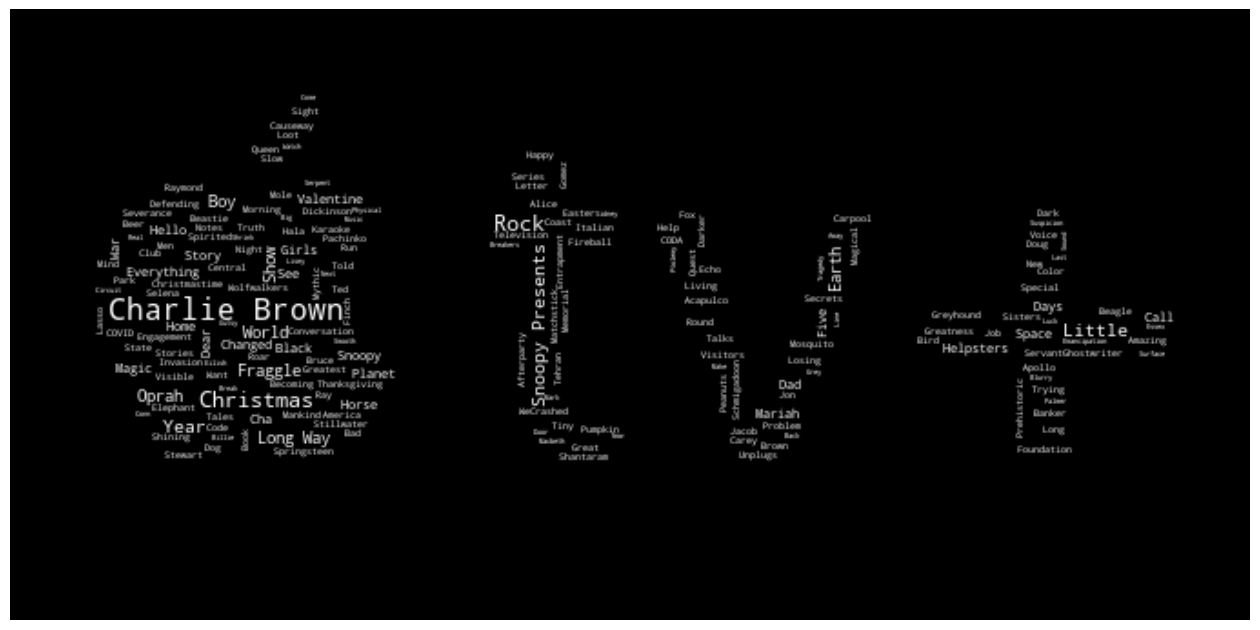

In [90]:
# Define a function to specify the text color
def paramount_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#ffffff"

custom_mask = np.array(Image.open('apple.jpg')) 
wc = WordCloud(
               stopwords = stopwords,
               mask = custom_mask,height = 2000, width = 4000, color_func = paramount_color)
#background_color = 'white',
wc.generate(title_corpus)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [91]:
showtime

,id,roberta_neg,roberta_neu,roberta_pos,title,type,description,release_year,age_certification,runtime,...,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,primary_genre,production_country,country_name,sentiment
0,tm1300,0.544892,0.390449,0.064658,A Charlie Brown Christmas,MOVIE,When Charlie Brown complains about the overwhe...,1965,G,25,...,0,tt0059026,8.3,40328.0,10.848,7.688,comedy,US,[United States],Negative
1,tm71152,0.184545,0.639140,0.176315,"It's the Great Pumpkin, Charlie Brown",MOVIE,"This classic ""Peanuts"" tale focuses on the thu...",1966,G,25,...,0,tt0060550,8.2,20299.0,12.458,7.474,animation,US,[United States],Neutral
2,tm2562,0.003088,0.021537,0.975375,A Charlie Brown Thanksgiving,MOVIE,"Turkey, cranberries, pumpkin pie... and the Pe...",1973,G,25,...,0,tt0068359,7.7,11406.0,12.591,7.311,family,US,[United States],Positive
3,tm125274,0.222083,0.517120,0.260797,"Be My Valentine, Charlie Brown",MOVIE,It's Valentine's Day again and Charlie Brown d...,1975,G,25,...,0,tt0072687,7.4,2777.0,6.981,7.000,animation,US,[United States],Neutral
4,tm106607,0.269473,0.526306,0.204221,"It's the Easter Beagle, Charlie Brown",MOVIE,"Charlie Brown, Linus and the entire Peanuts ga...",1974,G,25,...,0,tt0071679,7.5,3001.0,6.172,6.600,family,US,[United States],Neutral


In [93]:
numeric_columns = showtime.select_dtypes(include=[int, float])
numeric_columns

,roberta_neg,roberta_neu,roberta_pos,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,0.544892,0.390449,0.064658,1965,25,8.3,40328.0,10.848,7.688
1,0.184545,0.639140,0.176315,1966,25,8.2,20299.0,12.458,7.474
2,0.003088,0.021537,0.975375,1973,25,7.7,11406.0,12.591,7.311
3,0.222083,0.517120,0.260797,1975,25,7.4,2777.0,6.981,7.000
4,0.269473,0.526306,0.204221,1974,25,7.5,3001.0,6.172,6.600
...,...,...,...,...,...,...,...,...,...
165,0.742936,0.233991,0.023073,2023,0,7.4,1324.0,37.810,2.000
166,0.001336,0.068928,0.929736,2023,35,7.8,473.0,13.892,6.800
167,0.368264,0.551971,0.079765,2023,51,6.3,549.0,84.911,6.100
168,0.108228,0.742080,0.149692,2023,0,7.4,414.0,6.800,6.700


In [111]:
colors = ['#000000', '#666666', '#979797', '#eeeeee', '#0088cc']

fig = px.histogram(showtime, x='runtime', color_discrete_sequence=colors)

# Customize the layout if needed
fig.update_layout(
    title='Runtime Distribution of Content on Apple TV+',
    xaxis_title='Runtime',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.05
)

fig.show()

In [112]:
colors = ['#000000', '#666666', '#979797', '#eeeeee', '#0088cc']

fig = px.histogram(showtime, x='imdb_score', color_discrete_sequence=colors)

# Customize the layout if needed
fig.update_layout(
    title='IMDB score Distribution of Content on Apple TV+',
    xaxis_title='IMDB score',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.05
)

fig.show()

In [114]:
colors = ['#000000', '#666666', '#979797', '#eeeeee', '#0088cc']

fig = px.histogram(showtime, x='tmdb_score', color_discrete_sequence=colors)

# Customize the layout if needed
fig.update_layout(
    title='TMDB score Distribution of Content on Apple TV+',
    xaxis_title='TMDB score',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.05
)

fig.show()

In [116]:

colors = ['#000000', '#666666', '#979797', '#eeeeee', '#0088cc']

fig = px.histogram(showtime, x='release_year', color_discrete_sequence=colors)

# Customize the layout if needed
fig.update_layout(
    title='Release Year Distribution of Content on Apple TV+',
    xaxis_title='Release Year',
    yaxis_title='Count of Content', title_x = 0.5, bargap=0.05
)

fig.show()

In [108]:
numeric_columns

,roberta_neg,roberta_neu,roberta_pos,release_year,runtime,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,0.544892,0.390449,0.064658,1965,25,8.3,40328.0,10.848,7.688
1,0.184545,0.639140,0.176315,1966,25,8.2,20299.0,12.458,7.474
2,0.003088,0.021537,0.975375,1973,25,7.7,11406.0,12.591,7.311
3,0.222083,0.517120,0.260797,1975,25,7.4,2777.0,6.981,7.000
4,0.269473,0.526306,0.204221,1974,25,7.5,3001.0,6.172,6.600
...,...,...,...,...,...,...,...,...,...
165,0.742936,0.233991,0.023073,2023,0,7.4,1324.0,37.810,2.000
166,0.001336,0.068928,0.929736,2023,35,7.8,473.0,13.892,6.800
167,0.368264,0.551971,0.079765,2023,51,6.3,549.0,84.911,6.100
168,0.108228,0.742080,0.149692,2023,0,7.4,414.0,6.800,6.700


In [117]:
apple_credits = pd.read_csv('apple_credits.csv')

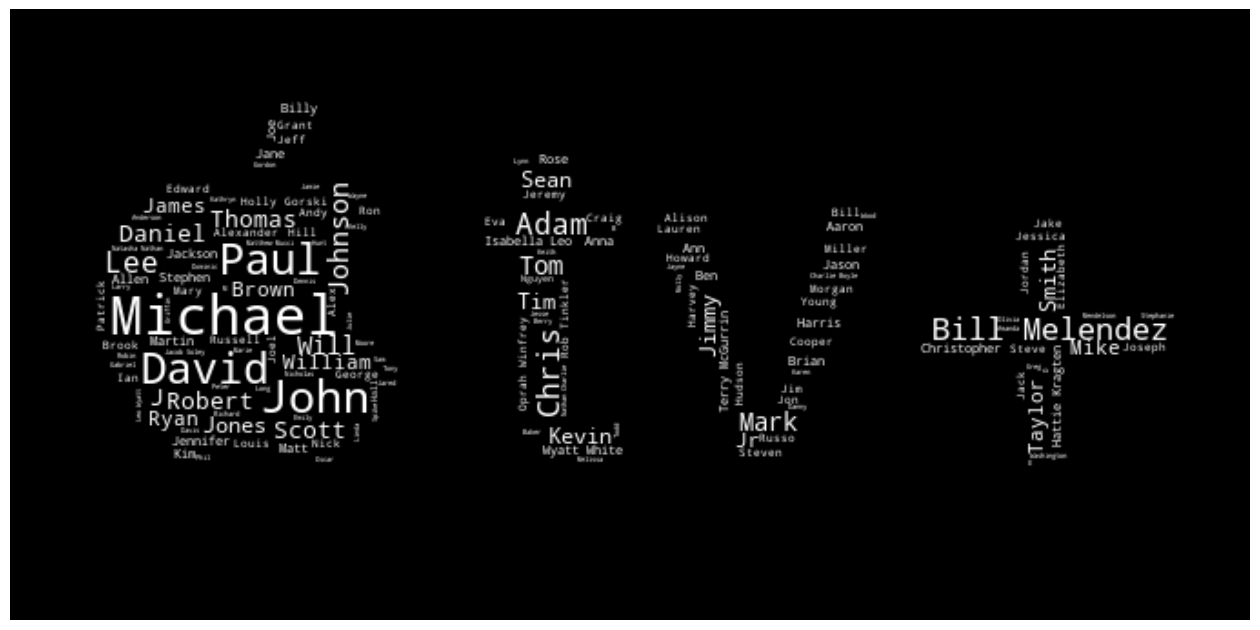

In [119]:
# most popular actor on amazon prime
apple_credits['name'] = apple_credits['name'].astype(str)
name_corpus = ' '.join(apple_credits['name'])

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image #to load our image
stopwords = set(STOPWORDS)

# Define a function to specify the text color
def disney_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#ffffff"

custom_mask = np.array(Image.open('apple.jpg')) 
wc = WordCloud(
               stopwords = stopwords,
               mask = custom_mask,height = 2000, width = 4000, color_func = disney_color)
#background_color = 'white',
wc.generate(name_corpus)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()